In [ ]:
import numpy as np
import tensorflow as tf
import cv2
import requests
import os
from PIL import Image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
import efficientnet.tfkeras as efn
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model


In [10]:
# Utilizando webscrapping en Unplash, descargamos una galería de imágenes de archivo de un 
# objeto determinado.

def descarga_imagen(imagen):
    # Access Key de Unsplash
    ACCESS_KEY = "0byE1o41WexZQJRM5Gy0N2NQIw36GLyZY6XcrUyf_M8"

    # Carpeta donde guardar las imágenes
    output_folder = f"./imagenes/{imagen}"
    os.makedirs(output_folder, exist_ok=True)

    # Palabra clave para buscar imágenes
    query = imagen  # Cambia esto por lo que necesites

    # Número total de imágenes deseadas
    total_images = 100  
    per_page = 30  # Máximo 30 imágenes por solicitud
    num_pages = (total_images // per_page) + 1  # Número de páginas necesarias

    # Descargar imágenes de varias páginas
    img_count = 0
    for page in range(1, num_pages + 1):  # Hacer solicitudes desde page=1 hasta page=num_pages
        print(f"🔍 Descargando página {page}...")

        # URL de la API con paginación
        url = f"https://api.unsplash.com/search/photos?query={query}&per_page={per_page}&page={page}&client_id={ACCESS_KEY}"

        # Hacer la solicitud a la API
        response = requests.get(url)

        # Intentar convertir la respuesta a JSON
        try:
            data = response.json()
        except Exception as e:
            print("Error al convertir la respuesta a JSON:", e)
            print("Respuesta de la API:", response.text)
            exit()

        # Verificar si "results" está en la respuesta
        if "results" not in data:
            print("ERROR: La API no devolvió 'results'. Esto es lo que devolvió:")
            print(data)  # Mostrar la respuesta completa para ver qué está pasando
            exit()

        # Si todo está bien, continuar con la descarga
        for img in data["results"]:
            if img_count >= total_images:
                print("Descarga completada.")
                break  # Detener si ya descargamos suficientes imágenes

            img_url = img["urls"]["full"]  # URL de la imagen en alta calidad
            img_response = requests.get(img_url)

            # Guardar la imagen
            img_path = os.path.join(output_folder, f"{query}_{img_count}.jpg")
            with open(img_path, "wb") as file:
                file.write(img_response.content)

            #print(f"Imagen descargada: {img_path}")
            img_count += 1
    return


In [34]:
descarga_imagen("dog")

🔍 Descargando página 1...
🔍 Descargando página 2...
🔍 Descargando página 3...
🔍 Descargando página 4...
Descarga completada.


In [ ]:
# Hasta aquí todo OK

In [ ]:
# ENTRENANDO EL MODELO

In [ ]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


In [35]:
# Cargar el modelo base
base_model = tf.keras.applications.EfficientNetB0(weights='imagenet', include_top=False)

x = base_model.output
x = GlobalAveragePooling2D()(x)
predictions = Dense(3, activation='softmax')(x)  # Usamos a softmax para multiclase, 3 es el número de clases

model = Model(inputs=base_model.input, outputs=predictions)

# Congelar/descongelar capas según se necesite
for layer in model.layers[-20:]:
    layer.trainable = True

# Compilar el modelo para multiclase
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Directorios de datos
base_dir = './imagenes'

# Configuración del aumento de datos
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=60,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Generadores para train y validation
train_generator = datagen.flow_from_directory(
    directory=os.path.join(base_dir, 'train'),
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'  # Cambiamos a 'categorical' para multiclase
)

validation_generator = datagen.flow_from_directory(
    directory=os.path.join(base_dir, 'validation'),
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'  # Cambiamos a 'categorical' para multiclase
)

# Entrenar el modelo
model.fit(
    train_generator,
    epochs=3,  
    validation_data=validation_generator
)

model.save('my_model.keras')

Found 300 images belonging to 3 classes.
Found 63 images belonging to 3 classes.
Epoch 1/3
10/10 ━━━━━━━━━━━━━━━━━━━━ 689s 49s/step - accuracy: 0.4315 - loss: 1.0395 - val_accuracy: 0.3333 - val_loss: 1.1294
Epoch 2/3
10/10 ━━━━━━━━━━━━━━━━━━━━ 383s 39s/step - accuracy: 0.8350 - loss: 0.6529 - val_accuracy: 0.3333 - val_loss: 1.1961
Epoch 3/3
 8/10 ━━━━━━━━━━━━━━━━━━━━ 1:04 32s/step - accuracy: 0.9195 - loss: 0.4281

Accuracy final de entrenamiento: 0.5600
Accuracy final de validación: 0.5000
Loss final de entrenamiento: 0.7044
Loss final de validación: 0.6962
2/2 ━━━━━━━━━━━━━━━━━━━━ 87s 37s/step


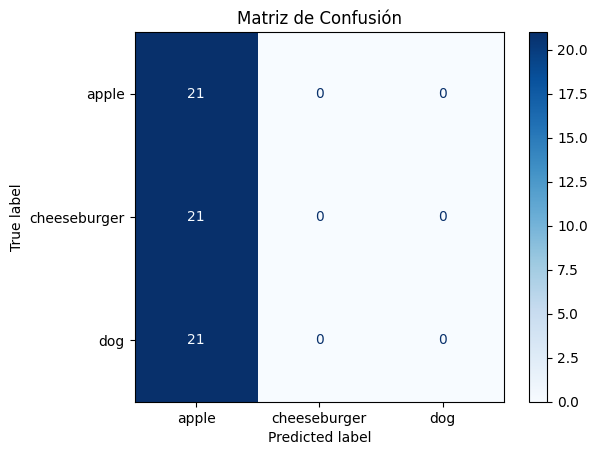

In [36]:
# Imprimir la última métrica de cada tipo al finalizar el entrenamiento
final_accuracy = history.history['accuracy'][-1]
final_val_accuracy = history.history['val_accuracy'][-1]
final_loss = history.history['loss'][-1]
final_val_loss = history.history['val_loss'][-1]

print(f"Accuracy final de entrenamiento: {final_accuracy:.4f}")
print(f"Accuracy final de validación: {final_val_accuracy:.4f}")
print(f"Loss final de entrenamiento: {final_loss:.4f}")
print(f"Loss final de validación: {final_val_loss:.4f}")

# Predicción
validation_generator.reset()  # Asegúrate de que el generador esté en el estado inicial
predictions = model.predict(validation_generator)
predicted_classes = np.argmax(predictions, axis=1)

# Etiquetas verdaderas
true_classes = validation_generator.classes

# Nombres de las clases
class_labels = list(validation_generator.class_indices.keys())

# Calcular la matriz de confusión
cm = confusion_matrix(true_classes, predicted_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)

# Visualizar la matriz de confusión
disp.plot(cmap=plt.cm.Blues)
plt.title('Matriz de Confusión')
plt.show()

In [ ]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model

# Carga el modelo entrenado
model = load_model('my_model.keras')

def preprocess_image(img_path, target_size=(224, 224)):
    # Carga la imagen y redimensiona
    img = image.load_img(img_path, target_size=target_size)
    # Convierte la imagen a array
    img_array = image.img_to_array(img)
    # Expande las dimensiones para que sea compatible con el modelo
    img_array = np.expand_dims(img_array, axis=0)
    # Normaliza la imagen
    img_array /= 255.0
    return img_array

def predict_image(model, img_path):
    # Preprocesa la imagen
    img_array = preprocess_image(img_path)
    # Realiza la predicción
    prediction = model.predict(img_array)
    # Devuelve la clase con mayor probabilidad
    predicted_class = np.argmax(prediction, axis=1)[0]
    return predicted_class


1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
La imagen pertenece a la clase: cheeseburger


In [41]:

# Ruta de tu imagen
img_path = 'imagenes/dog_23.jpg'

# Realizar la predicción
predicted_class_index = predict_image(model, img_path)
class_labels = ['cheeseburger', 'apple', 'dog']  # Asegúrate de que se alineen con tus clases

print(f"La imagen pertenece a la clase: {class_labels[predicted_class_index]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step
La imagen pertenece a la clase: cheeseburger


In [22]:
def predict_image(frame):
    # Cargar las etiquetas desde la URL proporcionada
    labels_url = 'https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt'
    response = requests.get(labels_url)
    labels = response.text.splitlines()

    num_classes = len(labels)  # Aquí asumimos que hay tantas clases como etiquetas

    # Cargar el modelo base y añadir capas específicas de ajuste fino
    base_model = efn.EfficientNetB0(weights='imagenet', include_top=False)
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    predictions_layer = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions_layer)

    # Congelar las capas base del modelo para entrenar solo las nuevas
    for layer in base_model.layers:
        layer.trainable = False

    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

    # Redimensionar y preprocesar el frame de entrada
    frame = cv2.resize(frame, (224, 224))
    cv2.imshow('image',frame)
    cv2.waitKey(0)

    frame_array = np.array(frame) / 255.0
    frame_array = np.expand_dims(frame_array, axis=0)

    # Realizar la predicción
    prediction_probs = model.predict(frame_array)
    predicted_index = np.argmax(prediction_probs)
    predicted_label = labels[predicted_index]

    return predicted_label

In [ ]:

# Pasamos la imagen por el modelo y guardamos en otra carpeta las que detecta correctamente:

def detecta_imagen(imagen):
    
    img_count = 0
    folder_path = f"./imagenes/{imagen}"
    #folder_path = os.path.join(".", "imagenes", imagen)  

    # Iterar sobre cada archivo en la carpeta
    for filename in os.listdir(folder_path):
        if filename.endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):  # Filtra solo archivos de imagen
            file_path = os.path.join(folder_path, filename)  # Construye la ruta completa al archivo
            try:
                with Image.open(file_path) as img:  # Abre la imagen
                    img_resized = cv2.resize(img, (224, 224)) #Adaptamos la imagen al tamaño que lee bien el modelo.
                    img_array = tf.keras.applications.mobilenet_v2.preprocess_input(img_resized[np.newaxis, ...])
                    prediction = predict_image(img_array)
                    if prediction == imagen: # Guarda la imagen verificada en otra carpeta:
                        # Guardar la imagen
                        img_count += 1
                        output_folder = f"./imagenes/{imagen}_verificada"
                        img_path = os.path.join(output_folder, f"{imagen}_{img_count}.jpg")
                        with open(img_path, "wb") as file:
                            file.write(img_response.content)           
                    else:
                        print("No estoy seguro de qué estás haciendo. Intentemos otra vez.")
            except Exception as e:
                print(f"No se pudo procesar {filename}. Error: {e}")
    print(f"{img_count} imágenes procesadas correctamente")
    return

In [ ]:
img_count = 0
folder_path = f"./imagenes/cheeseburger"
#folder_path = os.path.join(".", "imagenes", imagen)  

# Iterar sobre cada archivo en la carpeta
for filename in os.listdir(folder_path):
    if filename.endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):  # Filtra solo archivos de imagen
        file_path = os.path.join(folder_path, filename)  # Construye la ruta completa al archivo
        img = cv2.imread(file_path)
        try:
            img_resized = cv2.resize(img, (224, 224)) #Adaptamos la imagen al tamaño que lee bien el modelo.
            img_array = tf.keras.applications.mobilenet_v2.preprocess_input(img_resized[np.newaxis, ...])
            prediction = predict_image(img_array)
            if prediction == "cheeseburger": # Guarda la imagen verificada en otra carpeta:
                # Guardar la imagen
                img_count += 1
                output_folder = f"./imagenes/cheeseburger_verificada"
                img_path = os.path.join(output_folder, f"cheeseburger_{img_count}.jpg")
                with open(img_path, "wb") as file:
                    file.write(img_response.content)           
            else:
                print("No estoy seguro de qué estás haciendo. Intentemos otra vez.")
        except Exception as e:
            print(f"No se pudo procesar {filename}. Error: {e}")
print(f"{img_count} imágenes procesadas correctamente")

In [ ]:
# Cargar el modelo guardado
model = load_model('my_model.keras')

# Entrenar el modelo
history = model.fit(
    train_generator,
    epochs=3,  # Ajusta según necesites
    validation_data=validation_generator
)
model.save('my_model.keras')

Found 200 images belonging to 2 classes.
Found 42 images belonging to 2 classes.


c:\Users\Usuario\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/3
7/7 ━━━━━━━━━━━━━━━━━━━━ 387s 47s/step - accuracy: 0.4259 - loss: 0.7293 - val_accuracy: 0.5000 - val_loss: 0.6962
Epoch 2/3
7/7 ━━━━━━━━━━━━━━━━━━━━ 243s 39s/step - accuracy: 0.4719 - loss: 0.7079 - val_accuracy: 0.5000 - val_loss: 0.6959
Epoch 3/3
7/7 ━━━━━━━━━━━━━━━━━━━━ 242s 36s/step - accuracy: 0.5740 - loss: 0.7033 - val_accuracy: 0.5000 - val_loss: 0.6962


In [ ]:
# Generar predicciones para el conjunto de validación
validation_generator.reset()  # Reiniciar el generador
predictions = model.predict(validation_generator)
predicted_classes = np.where(predictions > 0.5, 1, 0)  # Convertir probabilidades en clases, umbral 0.5

# Etiquetas verdaderas
true_classes = validation_generator.classes

# Nombres de las clases
class_labels = list(validation_generator.class_indices.keys())

# Matriz de confusión
cm = confusion_matrix(true_classes, predicted_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)

# Mostrar la matriz de confusión
disp.plot(cmap=plt.cm.Blues)
plt.title('Matriz de Confusión')
plt.show()

In [24]:

image_path = os.path.join('.','imagenes/cheeseburger','cheeseburger_4.jpg')
frame = cv2.imread(image_path)

prediction = predict_image(frame)
print(prediction)



1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
brass


In [ ]:
detecta_imagen("cheeseburguer")

FileNotFoundError: [WinError 3] El sistema no puede encontrar la ruta especificada: '.\\imagenes\\cheeseburguer'